In [19]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

try:
    import urllib
    from urllib import urlretrieve
except Exception:
    import urllib.request as urllib
from os import path
import os
import numpy as np
from torchmetrics.classification import MulticlassCalibrationError
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

## Loading the MakeMoons Data

In [20]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
seed_value = 43
X, y = make_moons(n_samples=1000, noise=0.3, random_state=seed_value)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=seed_value)

class_0 = X_train[y_train == 0]
class_1 = X_train[y_train == 1]


X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float).reshape((-1,1))
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float).reshape((-1,1))

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800, 1]),
 torch.Size([200, 2]),
 torch.Size([200, 1]))

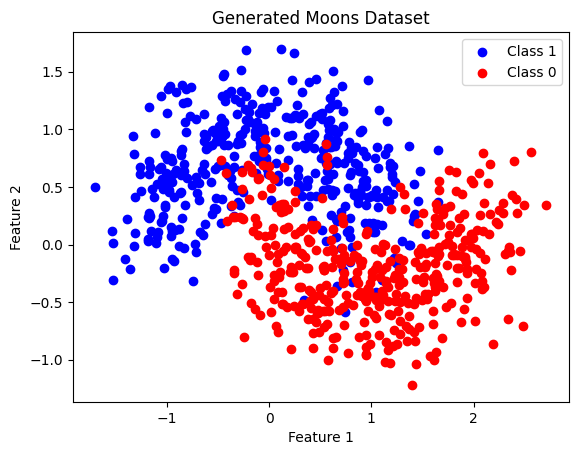

In [22]:
import matplotlib.pyplot as plt

# Separate data points by class
# class_0 = X[y == 0]
# class_1 = X[y == 1]
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=43)

# Create a scatter plot # Changed class color for consistency across graphs
plt.scatter(class_0[:, 0], class_0[:, 1], label="Class 1",color='blue')
plt.scatter(class_1[:, 0], class_1[:, 1], label="Class 0",color='red')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Moons Dataset")
plt.legend()
plt.show()

## Bayesian Neural Networks using Hamiltorch

In [7]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x= self.fc3(x)
#         x = F.softmax(self.fc3(x))
        return x
net = Net()

In [8]:
tau_list = []
tau = 10.#./100. # 1/50
for w in net.parameters():
#     print(w.nelement())
#     tau_list.append(tau/w.nelement())
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [9]:
hamiltorch.set_random_seed(seed_value)

params_init = hamiltorch.util.flatten(net).to(device).clone()
print(params_init.shape)

step_size = 0.001#0.01# 0.003#0.002
num_samples = 1000#2000 # 3000
L = 20 #3
tau_out = 1.
normalizing_const = 1.
burn =100 # GPU: 3000

params_hmc = hamiltorch.sample_model(net, X_train, y_train, params_init=params_init, model_loss='multi_class_linear_output', num_samples=num_samples, burn = burn,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const)


torch.Size([10602])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:53 | 0d:00:00:00 | #################### | 1000/1000 | 18.81       
Acceptance Rate 0.99


In [ ]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x = X_test, y = y_test, samples=params_hmc, model_loss='multi_class_log_softmax_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc = []
acc = torch.zeros( int(len(params_hmc))-1)
nll = torch.zeros( int(len(params_hmc))-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)

mcce = MulticlassCalibrationError(num_classes=2, n_bins=2)#, norm='l2')

for s in range(1,len(params_hmc)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc[s-1] = (pred.float() == y_test.flatten()).sum().float()/y_test.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
#     print(ensemble_proba.cpu()/(s+1),y_test[:].long().cpu().flatten())
    
    out_calibration_error = mcce(ensemble_proba.cpu()/(s+1), y_test[:].long().cpu().flatten())
    print(out_calibration_error)
    nll[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_test[:].long().cpu().flatten(), reduction='mean')

CPU times: user 3.23 s, sys: 7.62 ms, total: 3.24 s
Wall time: 624 ms
tensor(0.1696)
tensor(0.1176)
tensor(0.0939)
tensor(0.0816)
tensor(0.0699)
tensor(0.0601)
tensor(0.0581)
tensor(0.0528)
tensor(0.0489)
tensor(0.0456)
tensor(0.0473)
tensor(0.0393)
tensor(0.0366)
tensor(0.0341)
tensor(0.0328)
tensor(0.0315)
tensor(0.0304)
tensor(0.0347)
tensor(0.0338)
tensor(0.0385)
tensor(0.0380)
tensor(0.0378)
tensor(0.0370)
tensor(0.0361)
tensor(0.0352)
tensor(0.0343)
tensor(0.0330)
tensor(0.0324)
tensor(0.0315)
tensor(0.0308)
tensor(0.0302)
tensor(0.0297)
tensor(0.0340)
tensor(0.0334)
tensor(0.0329)
tensor(0.0322)
tensor(0.0315)
tensor(0.0309)
tensor(0.0303)
tensor(0.0297)
tensor(0.0292)
tensor(0.0288)
tensor(0.0284)
tensor(0.0281)
tensor(0.0279)
tensor(0.0277)
tensor(0.0274)
tensor(0.0272)
tensor(0.0271)
tensor(0.0269)
tensor(0.0267)
tensor(0.0266)
tensor(0.0265)
tensor(0.0265)
tensor(0.0265)
tensor(0.0263)
tensor(0.0262)
tensor(0.0262)
tensor(0.0263)
tensor(0.0263)
tensor(0.0263)
tensor(0.0264)


In [ ]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc,label="Accuracy")
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(nll,label="Loss")
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
# Get posterior predictive over the 2D grid
posterior_samples = params_hmc#.detach()
# Consider burning the first 100 samples
posterior_samples = posterior_samples#[1000:]
y_preds = []
n_grid = 200
lims = 4
twod_grid = torch.tensor(np.meshgrid(np.linspace(-lims, lims, n_grid), np.linspace(-lims, lims, n_grid))).float().to(device)
with torch.no_grad():
    for theta in posterior_samples:
        params_list = hamiltorch.util.unflatten(net, theta)
        params = net.state_dict()
        for i, (name, _) in enumerate(params.items()):
            params[name] = params_list[i]
        y_pred = torch.func.functional_call(net, params, twod_grid.view(2, -1).T).squeeze()

        y_preds.append(y_pred[:,0])

In [ ]:
logits = torch.stack(y_preds).mean(axis=0).reshape(n_grid, n_grid)
probs = torch.sigmoid(logits)

In [ ]:
# Plot the posterior predictive distribution decision boundary
plt.figure()
plt.contourf(twod_grid[0].cpu().numpy(), twod_grid[1].cpu().numpy(), probs.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.colorbar()
scatter = plt.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("BNN: Mean value prediction")
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 1', 'Class 0'])
plt.show()

In [ ]:
# Plot the variance of the posterior predictive distribution
plt.figure()
plt.contourf(twod_grid[0].cpu().numpy(), twod_grid[1].cpu().numpy(), torch.stack(y_preds).std(axis=0).reshape(n_grid, n_grid).cpu().numpy(), cmap='bwr', alpha=0.5)
scatter = plt.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.colorbar()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("BNN: Variance/Uncertainty in prediction")
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 1', 'Class 0'])
plt.show()

## Gaussian Processes using GPy

In [96]:
import GPy
n_samples = 5

n_grid = 200
lims = 4
tot_itr = 6
twod_grid = torch.tensor(np.meshgrid(np.linspace(-lims, lims, n_grid), 
                                     np.linspace(-lims, lims, n_grid))).float().to(device)
y_preds = []
acc=[]
acc = torch.zeros( int((tot_itr)))

for i in range(n_samples):
    m = GPy.models.GPClassification(X_train.detach().numpy(),y_train.detach().numpy())
    out_pred = m.predict(X_test.cpu().numpy())
    pred = (out_pred[0].flatten() > 0.5)
    acc[0] = (torch.tensor(pred) == y_test.flatten()).sum().float()/y_test.shape[0]
    for itr in range(1,tot_itr):
        m.optimize('bfgs', max_iters=10) #first runs EP and then optimizes the kernel parameters
        print('iteration:', itr)
        print(m)
        print("")
        out_pred = m.predict(X_test.cpu().numpy())
        pred = (out_pred[0].flatten() > 0.5)
        acc[itr] = (torch.tensor(pred) == y_test.flatten()).sum().float()/y_test.shape[0]
    
    simY, simMse = m.predict(twod_grid.view(2, -1).T.detach().numpy())#(twod_grid.view(2, -1).T)
    y_preds.append(simY)
    


iteration: 1

Name : gp_classification
Objective : 184.16235705158658
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |   5.040757877455086  |      +ve      |        
  rbf.lengthscale     |  0.8552771593894865  |      +ve      |        

iteration: 2

Name : gp_classification
Objective : 179.35938245401292
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |              value  |  constraints  |  priors
  rbf.variance        |  8.743655327372899  |      +ve      |        
  rbf.lengthscale     |  0.899300610196199  |      +ve      |        

iteration: 3

Name : gp_classification
Objective : 179.0021645227086
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  

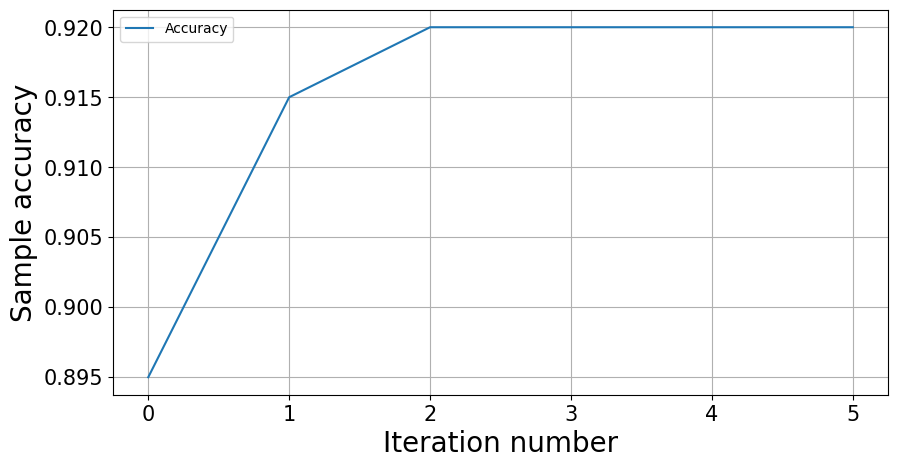

In [97]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc,label="Accuracy")
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [98]:
# Subtracting from 1 since GP predicts for class 0 , and maintain color consistency across models
probs = 1-np.stack(y_preds).mean(axis=0).reshape(n_grid, n_grid)

In [99]:
# m.plot(plot_density=True)#m.plot()
# m.plot_f(plot_density=True)
# # m.plot_f()

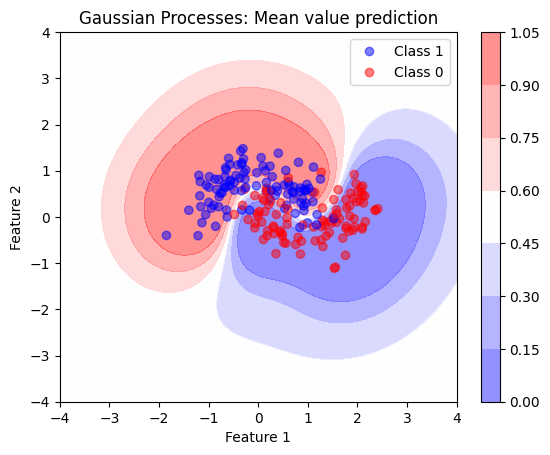

In [100]:
# Plot the posterior predictive distribution decision boundary
plt.figure()
plt.contourf(twod_grid[0].cpu().numpy(), twod_grid[1].cpu().numpy(), probs, cmap='bwr', alpha=0.5)
plt.colorbar
scatter = plt.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), 
                      c=y_test.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Gaussian Processes: Mean value prediction")
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 1', 'Class 0'])
plt.show()

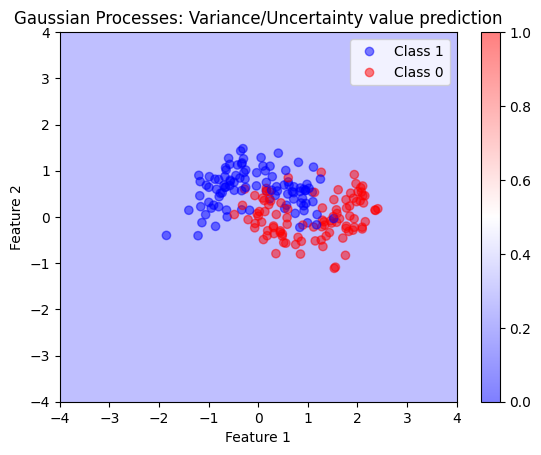

In [101]:
# Plot the variance of the posterior predictive distribution
plt.figure()
plt.contourf(twod_grid[0].cpu().numpy(), twod_grid[1].cpu().numpy(), np.stack(y_preds).std(axis=0).reshape(n_grid, n_grid), cmap='bwr', alpha=0.5)
scatter = plt.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.colorbar()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Gaussian Processes: Variance/Uncertainty value prediction")
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 1', 'Class 0'])
plt.show()

## Bayesian Logistic Regression using Hamiltorch

In [31]:
class Net(nn.Module):

    def __init__(self, layer_sizes, loss = 'multi_class', bias=True):
        super(Net, self).__init__()
        self.layer_sizes = layer_sizes
        self.layer_list = []
        self.loss = loss
        self.bias = bias
        self.l1 = nn.Linear(layer_sizes[0], layer_sizes[1],bias = self.bias)

    def forward(self, x):
        x = self.l1(x)

        return x

layer_sizes = [2,2]
net = Net(layer_sizes)
    

print(net)

Net(
  (l1): Linear(in_features=2, out_features=2, bias=True)
)


In [32]:
## Set hyperparameters for network

tau_list = []
tau = 1.#/100. # iris 1/10
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [34]:
# hamiltorch.set_random_seed(123)
params_init = hamiltorch.util.flatten(net).to(device).clone()

step_size = 0.1 
num_samples = 1000
L = 20
tau_out = 1.

params_hmc = hamiltorch.sample_model(net, X_train, y_train, params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,tau_list=tau_list)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:17 | 0d:00:00:00 | #################### | 1000/1000 | 57.56       
Acceptance Rate 0.80


In [35]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x=X_test, y=y_test, samples=params_hmc[:], model_loss='multi_class_linear_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc = torch.zeros( len(pred_list)-1)
nll = torch.zeros( len(pred_list)-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)

mcce = MulticlassCalibrationError(num_classes=2, n_bins=2)#, norm='l2')

for s in range(1,len(pred_list)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc[s-1] = (pred.float() == y_test.flatten()).sum().float()/y_test.shape[0]
    
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
#     print(ensemble_proba.cpu()/(s+1),y_test[:].long().cpu().flatten())
    
    out_calibration_error = mcce(ensemble_proba.cpu()/(s+1), y_test[:].long().cpu().flatten())
    print(out_calibration_error)
    
    nll[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_test[:].long().cpu().flatten(), reduction='mean')

CPU times: user 2.18 s, sys: 19.9 ms, total: 2.2 s
Wall time: 316 ms
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0085)
tensor(0.0242)
tensor(0.0580)
tensor(0.0719)
tensor(0.0755)
tensor(0.0879)
tensor(0.0944)
tensor(0.0955)
tensor(0.0965)
tensor(0.1169)
tensor(0.1174)
tensor(0.1181)
tensor(0.1139)
tensor(0.1051)
tensor(0.1063)
tensor(0.1127)
tensor(0.1190)
tensor(0.1156)
tensor(0.1172)
tensor(0.1191)
tensor(0.1160)
tensor(0.1180)
tensor(0.1251)
tensor(0.1226)
tensor(0.1199)
tensor(0.1174)
tensor(0.1152)
tensor(0.1130)
tensor(0.1108)
tensor(0.1091)
tensor(0.1074)
tensor(0.1056)
tensor(0.1042)
tensor(0.0978)
tensor(0.0864)
tensor(0.0851)
tensor(0.0837)
tensor(0.0775)
tensor(0.0762)
tensor(0.0751)
tensor(0.0739)
tensor(0.0828)
tensor(0.0814)
tensor(0.0804)
tensor(0.0794)
tensor(0.0782)
tensor(0.0772)
t

tensor(0.0062)
tensor(0.0062)
tensor(0.0062)
tensor(0.0062)
tensor(0.0062)
tensor(0.0062)
tensor(0.0062)
tensor(0.0062)
tensor(0.0061)
tensor(0.0061)
tensor(0.0061)
tensor(0.0061)
tensor(0.0061)
tensor(0.0061)
tensor(0.0060)
tensor(0.0060)
tensor(0.0060)
tensor(0.0060)
tensor(0.0060)
tensor(0.0059)
tensor(0.0059)
tensor(0.0059)
tensor(0.0059)
tensor(0.0059)
tensor(0.0059)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0058)
tensor(0.0057)
tensor(0.0057)
tensor(0.0057)
tensor(0.0057)
tensor(0.0057)
tensor(0.0057)
tensor(0.0057)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0

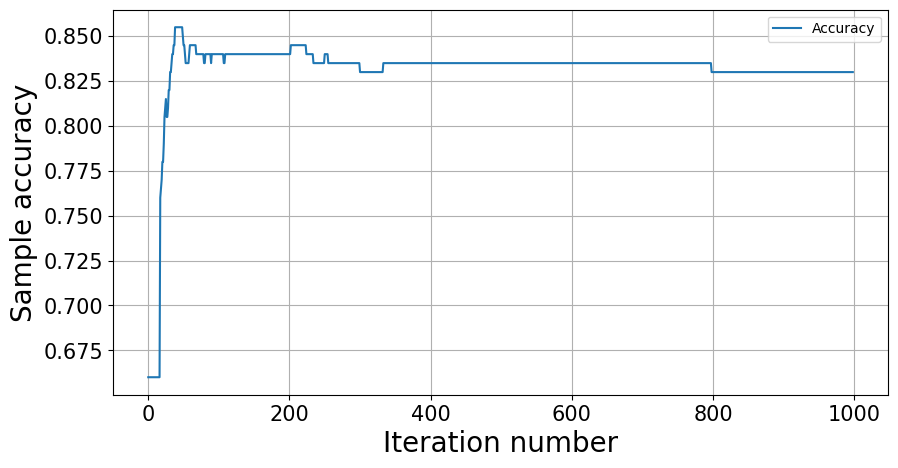

In [46]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc,label="Accuracy")
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.legend()
plt.show()

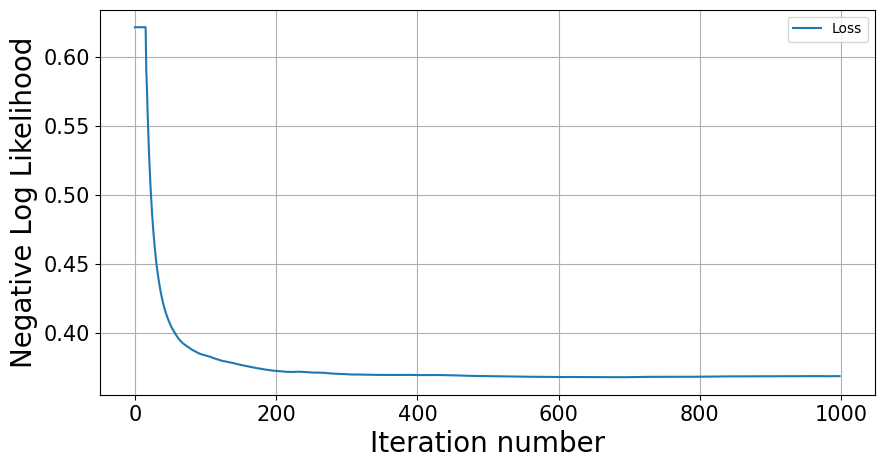

In [47]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(nll,label="Loss")
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.legend()
plt.show()

In [48]:
# Get posterior predictive over the 2D grid
posterior_samples = params_hmc#.detach()
# Consider burning the first 100 samples
posterior_samples = posterior_samples#[1000:]
y_preds = []
n_grid = 200
lims = 4
twod_grid = torch.tensor(np.meshgrid(np.linspace(-lims, lims, n_grid), np.linspace(-lims, lims, n_grid))).float().to(device)
with torch.no_grad():
    for theta in posterior_samples:
        params_list = hamiltorch.util.unflatten(net, theta)
        params = net.state_dict()
        for i, (name, _) in enumerate(params.items()):
            params[name] = params_list[i]
        y_pred = torch.func.functional_call(net, params, twod_grid.view(2, -1).T).squeeze()

        y_preds.append(y_pred[:,0])

In [49]:
logits = torch.stack(y_preds).mean(axis=0).reshape(n_grid, n_grid)
probs = torch.sigmoid(logits)

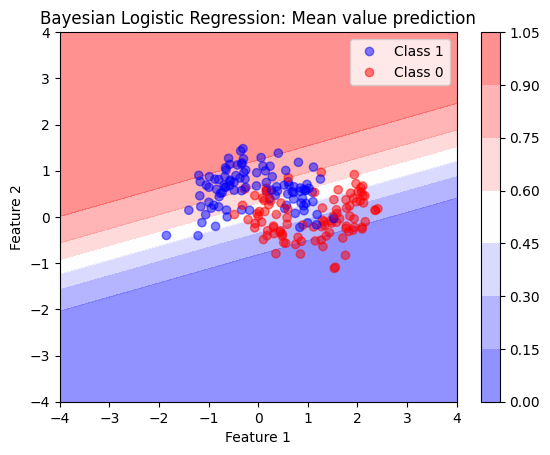

In [51]:
# Plot the posterior predictive distribution decision boundary
plt.figure()
plt.contourf(twod_grid[0].cpu().numpy(), twod_grid[1].cpu().numpy(), probs.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.colorbar()
scatter = plt.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Bayesian Logistic Regression: Mean value prediction")
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 1', 'Class 0'])
plt.show()

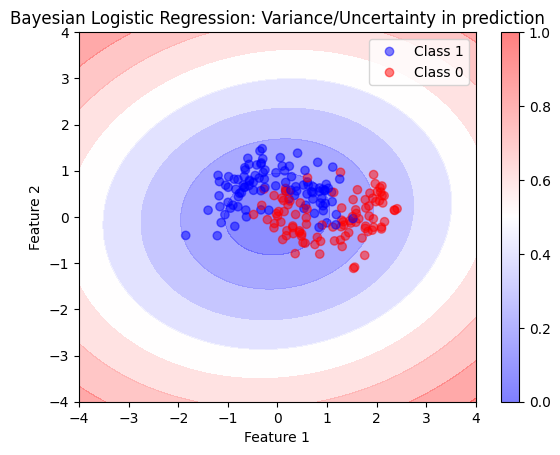

In [53]:
# Plot the variance of the posterior predictive distribution
plt.figure()
plt.contourf(twod_grid[0].cpu().numpy(), twod_grid[1].cpu().numpy(), torch.stack(y_preds).std(axis=0).reshape(n_grid, n_grid).cpu().numpy(), cmap='bwr', alpha=0.5)
scatter = plt.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), cmap='bwr', alpha=0.5)
plt.colorbar()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Bayesian Logistic Regression: Variance/Uncertainty in prediction")
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 1', 'Class 0'])
plt.show()

In [62]:
import matplotlib
matplotlib.__version__

'3.8.1'